## <div align="center"> TUGAS LAB IS388 Data Analysis </div>
## <div align="center"> WEEK [XX]: [Topic]</div>
#### <div align="center"> Semester Ganjil 2024/2025 </div>
---

In [2]:
import datetime
import uuid

studentName = "Nama"
studentNIM = "NIM"
studentClass = "Class"

In [4]:
myDate = datetime.datetime.now()
myDevice = str(uuid.uuid1())

print("Name: \t\t{}".format(studentName))
print("NIM: \t\t{}".format(studentNIM))
print("NIM: \t\t{}".format(studentClass))
print("Start: \t\t{}".format(myDate))
print("Device ID: \t{}".format(myDevice))

Name: 		Nama
NIM: 		NIM
NIM: 		Class
Start: 		2024-08-20 10:12:14.272617
Device ID: 	ff98d422-5ea1-11ef-8ac7-0045e2d68e9e


---

## <div align="center"> Unguided Lab </div>

### Enter Guided Lab Code Here:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix



In [12]:
# ==========================================
# PHASE 1: DATA UNDERSTANDING & LOADING
# ==========================================

# 1. Load WHO Reference Tables (The Rules)
# We reuse the loading logic to ensure we have the standards ready
def load_who_standards():
    files = {
        'who/bfa_boys_0_2': 'who/bfa_boys_0_2.csv', 'who/bfa_boys_2_5': 'who/bfa_boys_2_5.csv',
        'who/bfa_girls_0_2': 'who/bfa_girls_0_2.csv', 'who/bfa_girls_2_5': 'who/bfa_girls_2_5.csv',
        'who/hfa_boys_0_2': 'who/hfa_boys_0_2.csv', 'who/hfa_boys_2_5': 'who/hfa_boys_2_5.csv',
        'who/hfa_girls_0_2': 'who/hfa_girls_0_2.csv', 'who/hfa_girls_2_5': 'who/hfa_girls_2_5.csv',
        'who/wfa_boys': 'who/wfa_boys.csv', 'who/wfa_girls': 'who/wfa_girls.csv'
    }
    
    data = {}
    for key, path in files.items():
        # Load with semi-colon delimiter and comma decimal
        df = pd.read_csv(path, sep=';', decimal=',')
        df.columns = df.columns.str.strip()
        data[key] = df
        
    # Helper to merge 0-2 and 2-5
    def merge_segments(df1, df2):
        return pd.concat([df1, df2], ignore_index=True).sort_values('Month').drop_duplicates(subset=['Month'])

    standards = {
        'Male': {
            'WFA': data['who/wfa_boys'],
            'HFA': merge_segments(data['who/hfa_boys_0_2'], data['who/hfa_boys_2_5']),
            'BFA': merge_segments(data['who/bfa_boys_0_2'], data['who/bfa_boys_2_5'])
        },
        'Female': {
            'WFA': data['who/wfa_girls'],
            'HFA': merge_segments(data['who/hfa_girls_0_2'], data['who/hfa_girls_2_5']),
            'BFA': merge_segments(data['who/bfa_girls_0_2'], data['who/bfa_girls_2_5'])
        }
    }
    return standards

# 2. Load Real-World Data (Ethiopia Dataset)
df_real = pd.read_csv('malnutrition_children_ethiopia.csv', sep=';')

print("--- Real Data Overview ---")
print(df_real.head())
print(df_real.info())

--- Real Data Overview ---
   ID  Age (months)  Gender  Height_cm  Weight_kg
0   1            31    Male       84.1       19.2
1   2            38  Female       91.0        6.3
2   3             7  Female       61.4        5.8
3   4             7  Female      103.1       12.9
4   5             0    Male       78.9        7.4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098 entries, 0 to 4097
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            4098 non-null   int64  
 1   Age (months)  4098 non-null   int64  
 2   Gender        4098 non-null   object 
 3   Height_cm     4098 non-null   float64
 4   Weight_kg     4098 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 160.2+ KB
None


In [13]:
# ==========================================
# PHASE 2: DATA PREPARATION & LABELING
# ==========================================

standards = load_who_standards()

def calculate_z_score_and_label(row):
    """
    Looks up WHO standards for a child's age/gender 
    and calculates Z-scores for Weight, Height, and BMI.
    """
    gender = row['Gender']
    age = int(row['Age (months)'])
    
    # Validation: Age range check (0-60 months)
    if age > 60: return pd.Series([None, None, None, 'Exclude'])
    
    # Get standard tables
    tables = standards.get(gender)
    if not tables: return pd.Series([None, None, None, 'Exclude'])
    
    # Lookup LMS parameters
    try:
        wfa_row = tables['WFA'].loc[tables['WFA']['Month'] == age].iloc[0]
        hfa_row = tables['HFA'].loc[tables['HFA']['Month'] == age].iloc[0]
        bfa_row = tables['BFA'].loc[tables['BFA']['Month'] == age].iloc[0]
    except IndexError:
        return pd.Series([None, None, None, 'Exclude'])

    # Calculate BMI
    height_m = row['Height_cm'] / 100
    bmi = row['Weight_kg'] / (height_m ** 2)
    
    # Z-score Formula: Z = ((X/M)^L - 1) / (L*S)
    def get_z(measure, row_params):
        L, M, S = row_params['L'], row_params['M'], row_params['S']
        return ((measure / M) ** L - 1) / (L * S)
    
    z_weight = get_z(row['Weight_kg'], wfa_row)
    z_height = get_z(row['Height_cm'], hfa_row)
    z_bmi = get_z(bmi, bfa_row)
    
    # Define Ground Truth Labels
    # WHO Definitions: < -2 SD is Malnourished (Stunted, Underweight, or Wasted)
    status = 'Normal'
    if z_height < -2 or z_weight < -2 or z_bmi < -2:
        status = 'Malnourished'
        
    # Mark Outliers (Data Errors)
    # WHO recommends flagging |Z| > 5 or 6 as likely measurement errors
    if abs(z_height) > 6 or abs(z_weight) > 5 or abs(z_bmi) > 5:
        status = 'Data Error'
        
    return pd.Series([z_weight, z_height, z_bmi, status])

# Apply calculations
print("\nProcessing... Calculating Z-scores and Labels...")
df_processed = df_real.copy()
df_processed[['Z_Weight', 'Z_Height', 'Z_BMI', 'Status']] = df_processed.apply(calculate_z_score_and_label, axis=1)

# Remove Data Errors/Outliers
df_clean = df_processed[df_processed['Status'] != 'Data Error'].copy()
df_clean = df_clean[df_clean['Status'] != 'Exclude'].copy()

print(f"Original Count: {len(df_real)}")
print(f"Cleaned Count: {len(df_clean)}")
print(f"Removed {len(df_real) - len(df_clean)} rows (Outliers/Errors).")
print("\nClass Distribution:")
print(df_clean['Status'].value_counts())


Processing... Calculating Z-scores and Labels...
Original Count: 4098
Cleaned Count: 1415
Removed 2683 rows (Outliers/Errors).

Class Distribution:
Status
Malnourished    771
Normal          644
Name: count, dtype: int64


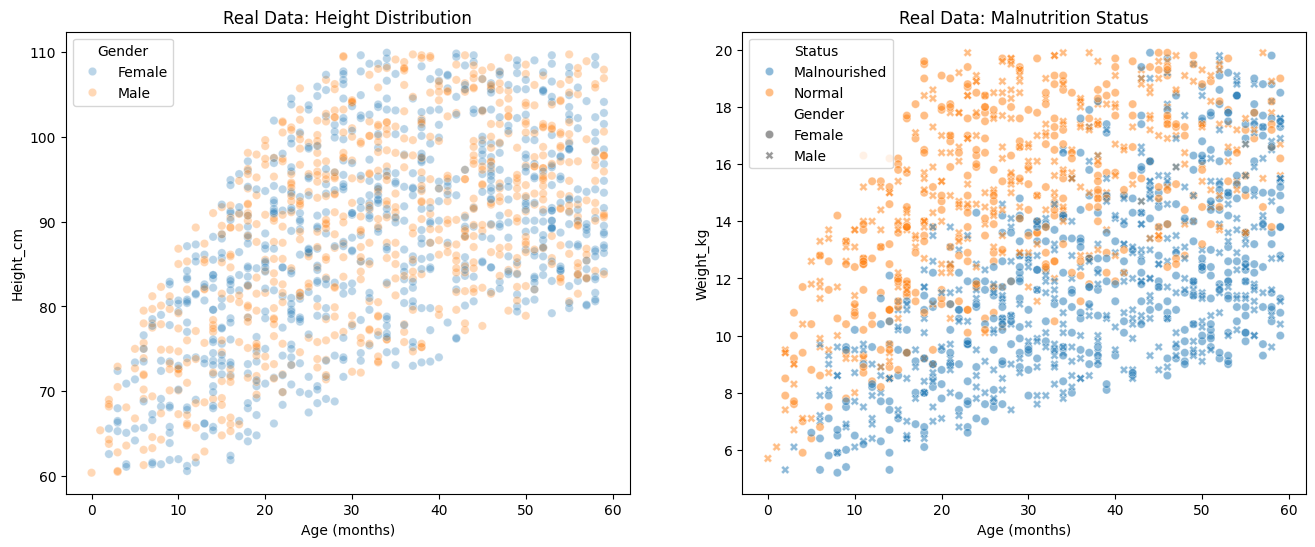

In [14]:
# ==========================================
# PHASE 3: EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================

# Visualize the Real Data on top of Standard Curves
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Height vs Age
sns.scatterplot(data=df_clean, x='Age (months)', y='Height_cm', hue='Gender', alpha=0.3, ax=ax[0])
ax[0].set_title('Real Data: Height Distribution')

# Plot 2: Weight vs Age
sns.scatterplot(data=df_clean, x='Age (months)', y='Weight_kg', hue='Status', style='Gender', alpha=0.5, ax=ax[1])
ax[1].set_title('Real Data: Malnutrition Status')
plt.show()

In [15]:
# ==========================================
# PHASE 4: DATA MODELING (Random Forest)
# ==========================================

# 1. Feature Engineering
# Convert Gender to numeric
df_clean['Gender_Code'] = df_clean['Gender'].map({'Male': 1, 'Female': 0})

# Features (Inputs)
X = df_clean[['Age (months)', 'Weight_kg', 'Height_cm', 'Gender_Code']]

# Target (Output) - Convert to binary 0/1 for the model
y = df_clean['Status'].map({'Normal': 0, 'Malnourished': 1})

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.



--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.96      0.91      0.93       126
Malnourished       0.93      0.97      0.95       157

    accuracy                           0.94       283
   macro avg       0.95      0.94      0.94       283
weighted avg       0.94      0.94      0.94       283



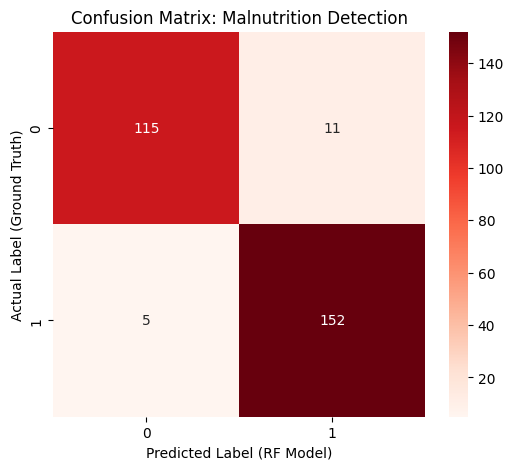

In [ ]:
# ==========================================
# PHASE 5: EVALUATION
# ==========================================

y_pred = rf_model.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Malnourished']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix: Malnutrition Detection')
plt.ylabel('Actual Label (Ground Truth)')
plt.xlabel('Predicted Label (RF Model)')
plt.show()
# confusion matrix 0 = normal, 1 = malnourished

----

## <div align="center"> Conclusion </div>

### Enter Your Conclusion Here:

----

In [18]:
studentName2 = "Nama2"
studentNIM2 = "NIM2"
studentClass2 = "Class2"

In [20]:
print("Name: \t\t{}".format(studentName2))
print("NIM: \t\t{}".format(studentNIM2))
print("NIM: \t\t{}".format(studentClass2))
print("End: \t\t{}".format(myDate))
print("Device ID: \t{}".format(myDevice))

Name: 		Nama2
NIM: 		NIM2
NIM: 		Class2
End: 		2024-08-20 10:12:14.272617
Device ID: 	ff98d422-5ea1-11ef-8ac7-0045e2d68e9e


----

## <div align="center"> Reference </div>

### Input Your Reference Here  (Jika ada):

----